![ML_SWE-2.jpg](./Images/ML_SWE.jpg)

# Data Preparation and Feature Engineering
Model data comes from the following sources National Resource Conservation Service (NRCS) Snow Telemetry (SNOTEL), California Data Exchange Center (CDEC), Copernicus 90-m DEM, and the NASA Airborne Snow Observatory (ASO).
Feature engineering creates new features to capture the influences of the time of year, latitude, longitude, and elevation on SWE dynamics.
Below is a generalized workflow for retrieving the data and engineering the following features for input into the machine learning models.

|Feature id| Description|
 |:-----------: | :--------: |
 |WY Week | Numerical ID of the week of the water year|
 |Latitude | Center latitude of the training grid cell |
 |Longitude | Center longitude of the training grid cell|
 |Elevation | DEM elevation of the training grid cell |
 |Northness | Calculated northness of the training cell|
 |SNOTEL SWE | Current week's observed SWE from SNOTEL|
 |Prev SNOTEL SWE | Previous week's observed SWE from SNOTEL|
 |Delta SNOTEL SWE | Difference between Previous week's and current week's observed SWE from SNOTEL|
 |Previous SWE | Observed SWE from previous week|
 
 *Note, the Previous SWE feature is an observation for model training and testing but will be predicted when forecating.*
 
 

### Data Processing/Retrievel Overview

Data processing is likley the most tedious part of the model development pipeline and uses the elevation, slope, and aspect derived from DEM data through nearest-neighbor interpolation to produce values for all training, testing, and inference locations based on the four latitude and longitude corners of each grid cell.

### Feature Engineering Overview
Feature engineering consists of creating terrain (i.e., northness), temporal, and snow features.

The calculation of the **northness metric** uses the slope and aspect values of each grid cell, using the embedded slope and aspect information within the metric to aid in ML model training and reducing the model dimensionality.

<img align = 'center' src="./Images/northness.JPG" alt = 'drawing' width = '300'/>

**Temporal features** support model training relative to seasonal snow accumulation and melt phases, consisting of a week-id as an integer from the beginning of the water year (WY) on October 1st.

**Snow observation features** utilize in-situ station SWE observations, using the values observed from the current (Snotel/CDEC SWE) and the previous observation (Previous Snotel/CDEC SWE) as inputs.
from current and previous observations, Delta SWE highlights the difference to capture the trend, either positive or negative, in SWE dynamics (i.e, melt or accumulation) with respect to each monitoring station ( $\Delta$ SWE).

**Grid cell previous observation features** capture the strong serial correlation of snow accumulation and melt on the SWE estimate, the model uses the SWE estimate of the previous week as a feature (Previous SWE).
For model training and testing, the Previous SWE input is from NASA ASO datasets while the hindcast uses the previous model SWE estimate.

### Below are simple data access and processing examples, please see the [National Snow Model Github](https://github.com/whitelightning450/National-Snow-Model) for complete examples.

## Loading Provided SWE Observations from Snowcast Showdown

The project supported the participation of the Snowcast Showdown, and while we shared useful code for SNOTEL and CDEC data retrievel (needed for forecasting), the information was provided by the United State Bureau of Reclaimation. 
We provide the supported modeling materials and provide the respective data processing and feature engineering steps.

In [1]:
import pandas as pd #need to pip install
import json 
from tqdm import tqdm #need to pip install
import warnings; warnings.filterwarnings("ignore")

In [2]:
#Set up training DF with key metadata per site
#All coordinates of 1 km polygon used to develop ave elevation, ave slope, ave aspect

colnames = ['cell_id', 'Region', 'BR_Coord', 'UR_Coord', 'UL_Coord', 'BL_Coord']
SWEdata = pd.DataFrame(columns = colnames)

#Load training SWE data
TrainSWE = pd.read_csv('data/Prediction_Location_Observations.csv')
#drop na and put into modeling df format
TrainSWE = TrainSWE.melt(id_vars=["cell_id"]).dropna()

#Load  SWE location data
with open("data/grid_cells.geojson") as f:
    data = json.load(f)
    
#load ground truth values(SNOTEL): training
GM_Train = pd.read_csv('data/ground_measures_train_features.csv')
#drop na and put into modeling df format
GM_Train = GM_Train.melt(id_vars=["station_id"]).dropna()

#load ground truth values (SNOTEL): Testing
GM_Test = pd.read_csv('data/ground_measures_test_features.csv')
#drop na and put into modeling df format
GM_Test = GM_Test.melt(id_vars=["station_id"]).dropna()

#load ground truth meta
GM_Meta = pd.read_csv('data/ground_measures_metadata.csv')

#merge training ground truth location metadata with snotel data
GM_Train = GM_Meta.merge(GM_Train, how='inner', on='station_id')
GM_Train = GM_Train.set_index('station_id')
GM_Train.rename(columns={'name': 'location', 'latitude': 'Lat', 'longitude': 'Long', 'value': 'SWE'}, inplace=True)


#merge testing ground truth location metadata with snotel data
GM_Test = GM_Meta.merge(GM_Test, how='inner', on='station_id')
GM_Test = GM_Test.set_index('station_id')
GM_Test.rename(columns={'name': 'location', 'latitude': 'Lat', 'longitude': 'Long', 'value': 'SWE'}, inplace=True)

#Make a SWE Grid location DF
for i in tqdm(range(len(data["features"]))):
    properties = data["features"][i]["properties"]
    location = data["features"][i]["geometry"]
    DFdata = [properties ["cell_id"],  properties ["region"],location ["coordinates"][0][0] ,
             location ["coordinates"][0][1], location ["coordinates"][0][2], location ["coordinates"][0][3] ]
    df_length = len(SWEdata)
    SWEdata.loc[df_length] = DFdata
    
#Make SWE location and observation DF
#Training
#merge site location metadata with observations
TrainSWE = TrainSWE.merge(SWEdata, how='inner', on='cell_id')
TrainSWE = TrainSWE.set_index('cell_id')
TrainSWE.rename(columns={'variable': 'Date', 'value': 'SWE'}, inplace=True)

#Make sure Date is in datetime data type
TrainSWE['Date'] = pd.to_datetime(TrainSWE['Date'])

100%|██████████| 18130/18130 [01:34<00:00, 191.67it/s]


## Selecting the Sierra Nevada Mountains as a demonstration region for the tutorial
For the tutorial, we select a subset of the region to reduce the computational burden on the end user which speeds up model development.

In [3]:
#For model tutorial, selecting the Northern Rockies (UCOL)
TrainSWE = TrainSWE[TrainSWE['Region'] =='sierras']
SWEdata = SWEdata[SWEdata['Region'] =='sierras']
GM_Train = GM_Train[GM_Train['state'] =='California']

In [4]:
display(TrainSWE.head(5))
print('There are: ', len(TrainSWE), ' training points in the Sierra dataset at ', len(TrainSWE.index.unique()), ' locations')

,Date,SWE,Region,BR_Coord,UR_Coord,UL_Coord,BL_Coord
cell_id,,,,,,,
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,sierras,"[-120.614398422312, 39.67242331310127]","[-120.614398422312, 39.6793373618521]","[-120.6233815751532, 39.6793373618521]","[-120.6233815751532, 39.67242331310127]"
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-08,21.5,sierras,"[-120.614398422312, 39.67242331310127]","[-120.614398422312, 39.6793373618521]","[-120.6233815751532, 39.6793373618521]","[-120.6233815751532, 39.67242331310127]"
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-15,22.2,sierras,"[-120.614398422312, 39.67242331310127]","[-120.614398422312, 39.6793373618521]","[-120.6233815751532, 39.6793373618521]","[-120.6233815751532, 39.67242331310127]"
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-22,22.2,sierras,"[-120.614398422312, 39.67242331310127]","[-120.614398422312, 39.6793373618521]","[-120.6233815751532, 39.6793373618521]","[-120.6233815751532, 39.67242331310127]"
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-29,23.0,sierras,"[-120.614398422312, 39.67242331310127]","[-120.614398422312, 39.6793373618521]","[-120.6233815751532, 39.6793373618521]","[-120.6233815751532, 39.67242331310127]"


There are:  37017  training points in the Sierra dataset at  4621  locations


In [5]:
display(GM_Train.head(5))
print('There are: ', len(GM_Train.index.unique()), ' monitoring stations in the Sierra dataset providing ', len(GM_Train), ' observations')

,location,elevation_m,Lat,Long,state,variable,SWE
station_id,,,,,,,
CDEC:ADM,Adin Mountain,1889.76,41.237,-120.792,California,1/1/2013,5.9
CDEC:ADM,Adin Mountain,1889.76,41.237,-120.792,California,1/8/2013,5.9
CDEC:ADM,Adin Mountain,1889.76,41.237,-120.792,California,1/15/2013,6.5
CDEC:ADM,Adin Mountain,1889.76,41.237,-120.792,California,1/22/2013,6.5
CDEC:ADM,Adin Mountain,1889.76,41.237,-120.792,California,1/29/2013,7.4


There are:  130  monitoring stations in the Sierra dataset providing  25111  observations


In [6]:
#Get Lat Long information
#Bottom right coord
TrainSWE[['BR_Coord_Long','BR_Coord_Lat']] = pd.DataFrame(TrainSWE.BR_Coord.tolist(), index= TrainSWE.index)

#Upper right coord
TrainSWE[['UR_Coord_Long','UR_Coord_Lat']] = pd.DataFrame(TrainSWE.UR_Coord.tolist(), index= TrainSWE.index)

#Upper left coord
TrainSWE[['UL_Coord_Long','UL_Coord_Lat']] = pd.DataFrame(TrainSWE.UL_Coord.tolist(), index= TrainSWE.index)

#Bottom Left coord
TrainSWE[['BL_Coord_Long','BL_Coord_Lat']] = pd.DataFrame(TrainSWE.BL_Coord.tolist(), index= TrainSWE.index)

### Getting Copernicus Geospatial Data - 90 m DEM

 <img align = 'right' src="./Images/DEM.jpg" alt = 'drawing' width = '600'/>
 
We use the copernicus 90 m DEM hosted by [Microsoft](https://planetarycomputer.microsoft.com) to provide the geospatial information for each training and testing location.
For each corner of each grid, we get the slope, elevation, and aspect, and calculate the average value to form as average 1-km geospatial information.
We use the following code to access the DEM:

In [7]:
#Develop a DF to get each site's geospatial information 
geocols = [ 'BR_Coord_Long', 'BR_Coord_Lat', 'UR_Coord_Long', 'UR_Coord_Lat',
       'UL_Coord_Long', 'UL_Coord_Lat', 'BL_Coord_Long', 'BL_Coord_Lat']


Geospatial_df = TrainSWE.copy()
Geospatial_df['rowid'] = Geospatial_df.index
Geospatial_df = Geospatial_df.drop_duplicates(subset = 'rowid')
Geospatial_df = pd.DataFrame(Geospatial_df[geocols])

#for the tutorial, we will just use a few sites for demonstration purposes
Geospatial_df = Geospatial_df.head(5)

#Define the AOI around the cell locations from clockwise

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            #lower left
            [Geospatial_df['BL_Coord_Long'].min(), Geospatial_df['BL_Coord_Lat'].min()],
            #upper left
            [Geospatial_df['UL_Coord_Long'].min(), Geospatial_df['UL_Coord_Lat'].max()],
            #upper right
            [Geospatial_df['UR_Coord_Long'].max(), Geospatial_df['UR_Coord_Lat'].max()],
            #lower right
            [Geospatial_df['UR_Coord_Long'].max(), Geospatial_df['BR_Coord_Lat'].min()],
            #lower left
            [Geospatial_df['BL_Coord_Long'].min(), Geospatial_df['BL_Coord_Lat'].min()],
        ]
    ],
}


In [8]:
area_of_interest

{'type': 'Polygon',
 'coordinates': [[[-120.8838930075479, 37.09569103644088],
   [-120.8838930075479, 39.78986799454153],
   [-118.5482732688371, 39.78986799454153],
   [-118.5482732688371, 37.09569103644088],
   [-120.8838930075479, 37.09569103644088]]]}

In [9]:
Geospatial_df

,BR_Coord_Long,BR_Coord_Lat,UR_Coord_Long,UR_Coord_Lat,UL_Coord_Long,UL_Coord_Lat,BL_Coord_Long,BL_Coord_Lat
cell_id,,,,,,,,
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.614398,39.672423,-120.614398,39.679337,-120.623382,39.679337,-120.623382,39.672423
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,-119.608285,38.275748,-119.608285,38.282800,-119.617268,38.282800,-119.617268,38.275748
147d5eb4-e574-47e4-994a-8a2908c06050,-120.874910,39.782965,-120.874910,39.789868,-120.883893,39.789868,-120.883893,39.782965
2700b724-e8c8-4715-acef-f448b252e07c,-119.518454,37.396032,-119.518454,37.403169,-119.527437,37.403169,-119.527437,37.396032
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.548273,37.095691,-118.548273,37.102856,-118.557256,37.102856,-118.557256,37.095691


In [10]:
#Make a connection to get 90m Copernicus Digital Elevation Model (DEM) data with the Planetary Computer STAC API
from pystac_client import Client #need to pip install
import planetary_computer #need to pip install

client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)


search = client.search(
    collections=["cop-dem-glo-90"],
    intersects=area_of_interest
)

tiles = list(search.get_items())

#Make a DF to connect locations with the larger data tile, and then extract elevations
regions = []

for i in tqdm(range(0, len(tiles))):
    row = [i, tiles[i].id]
    regions.append(row)
regions = pd.DataFrame(columns = ['sliceID', 'tileID'], data = regions)
regions = regions.set_index(regions['tileID'])
del regions['tileID']

100%|██████████| 9/9 [00:00<00:00, 74749.97it/s]


In [11]:
regions

,sliceID
tileID,
Copernicus_DSM_COG_30_N39_00_W121_00_DEM,0
Copernicus_DSM_COG_30_N39_00_W120_00_DEM,1
Copernicus_DSM_COG_30_N39_00_W119_00_DEM,2
Copernicus_DSM_COG_30_N38_00_W121_00_DEM,3
Copernicus_DSM_COG_30_N38_00_W120_00_DEM,4
Copernicus_DSM_COG_30_N38_00_W119_00_DEM,5
Copernicus_DSM_COG_30_N37_00_W121_00_DEM,6
Copernicus_DSM_COG_30_N37_00_W120_00_DEM,7
Copernicus_DSM_COG_30_N37_00_W119_00_DEM,8


The following codes blocks can take some time as we are connecting the geospatial attributes of each corner of each grid, and then taking the average to get averaged grid geospatial attributes.

In [12]:
#added Long,Lat to get polygon points
def GeoStat_func(i, Geospatial_df, regions, elev_L, slope_L, aspect_L, Long, Lat, tile):

    # convert coordinate to raster value
    lon = Geospatial_df.iloc[i][Long]
    lat = Geospatial_df.iloc[i][Lat]

    
    
    #connect point location to geotile
    tileid = 'Copernicus_DSM_COG_30_N' + str(math.floor(lat)) + '_00_W'+str(math.ceil(abs(lon))) +'_00_DEM'
    
    indexid = regions.loc[tileid]['sliceID']
    

   #Assing region
    signed_asset = planetary_computer.sign(tiles[indexid].assets["data"])
    #get elevation data in xarray object
    elevation = rioxarray.open_rasterio(signed_asset.href)

    #create copies to extract other geopysical information
    #Create Duplicate DF's
    slope = elevation.copy()
    aspect = elevation.copy()
        
    
    #transform projection
    transformer = Transformer.from_crs("EPSG:4326", elevation.rio.crs, always_xy=True)
    xx, yy = transformer.transform(lon, lat)
    
    #extract elevation values into numpy array
    tilearray = np.around(elevation.values[0]).astype(int)

    #set tile geo to get slope and set at rdarray
    geo = (math.floor(float(lon)), 90, 0.0, math.ceil(float(lat)), 0.0, -90)
    tilearray = rd.rdarray(tilearray, no_data = -9999)
    tilearray.projection = 'EPSG:4326'
    tilearray.geotransform = geo

    #get slope, note that slope needs to be fixed, way too high
    #get aspect value
    slope_arr = rd.TerrainAttribute(tilearray, attrib='slope_degrees')
    aspect_arr = rd.TerrainAttribute(tilearray, attrib='aspect')

    #save slope and aspect information 
    slope.values[0] = slope_arr
    aspect.values[0] = aspect_arr

    elev = round(elevation.sel(x=xx, y=yy, method="nearest").values[0])
    slop = round(slope.sel(x=xx, y=yy, method="nearest").values[0])
    asp = round(aspect.sel(x=xx, y=yy, method="nearest").values[0])
    
    
    #add point values to list
    elev_L.append(elev)
    slope_L.append(slop)
    aspect_L.append(asp)

In [13]:
import math
import rioxarray #need to pip install
from pyproj import Transformer
import numpy as np
import richdem as rd #mamba install richdem -c conda-forge

BLelev_L = []
BLslope_L = []
BLaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, BLelev_L, BLslope_L, BLaspect_L,
                'BL_Coord_Long', 'BL_Coord_Lat', tiles) for i in tqdm(range(0, len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['BL_Elevation_m'] = BLelev_L
Geospatial_df['BL_slope_Deg'] = BLslope_L
Geospatial_df['BLaspect_L'] = BLaspect_L


ULelev_L = []
ULslope_L = []
ULaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, ULelev_L, ULslope_L, ULaspect_L,
                'UL_Coord_Long', 'UL_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['UL_Elevation_m'] = ULelev_L
Geospatial_df['UL_slope_Deg'] = ULslope_L
Geospatial_df['ULaspect_L'] = ULaspect_L


URelev_L = []
URslope_L = []
URaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, URelev_L, URslope_L, URaspect_L,
                'UR_Coord_Long', 'UR_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['UR_Elevation_m'] = URelev_L
Geospatial_df['UR_slope_Deg'] = URslope_L
Geospatial_df['URaspect_L'] = URaspect_L


BRelev_L = []
BRslope_L = []
BRaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, BRelev_L, BRslope_L, BRaspect_L,
                'BR_Coord_Long', 'BR_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['BR_Elevation_m'] = BRelev_L
Geospatial_df['BR_slope_Deg'] = BRslope_L
Geospatial_df['BRaspect_L'] = BRaspect_L

  0%|          | 0/5 [00:00<?, ?it/s]
A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0955571====================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.134782======================= ] (99% - 0.0s - 1 threads)
 20%|██        | 1/5 [00:03<00:13,  3.46s/it]
A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.116795======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.111706======================= ] (99% - 0.0s - 1 threads)
 40%

In [14]:
Geospatial_df

,BR_Coord_Long,BR_Coord_Lat,UR_Coord_Long,UR_Coord_Lat,UL_Coord_Long,UL_Coord_Lat,BL_Coord_Long,BL_Coord_Lat,BL_Elevation_m,BL_slope_Deg,BLaspect_L,UL_Elevation_m,UL_slope_Deg,ULaspect_L,UR_Elevation_m,UR_slope_Deg,URaspect_L,BR_Elevation_m,BR_slope_Deg,BRaspect_L
cell_id,,,,,,,,,,,,,,,,,,,,
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.614398,39.672423,-120.614398,39.679337,-120.623382,39.679337,-120.623382,39.672423,2039,3,263,2050,1,286,2071,5,212,2070,4,291
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,-119.608285,38.275748,-119.608285,38.282800,-119.617268,38.282800,-119.617268,38.275748,2919,1,231,2868,5,348,2783,11,114,2876,24,358
147d5eb4-e574-47e4-994a-8a2908c06050,-120.874910,39.782965,-120.874910,39.789868,-120.883893,39.789868,-120.883893,39.782965,1999,19,169,2010,6,327,1966,13,351,2077,15,245
2700b724-e8c8-4715-acef-f448b252e07c,-119.518454,37.396032,-119.518454,37.403169,-119.527437,37.403169,-119.527437,37.396032,1987,9,256,2067,6,265,2100,11,35,2054,2,102
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.548273,37.095691,-118.548273,37.102856,-118.557256,37.102856,-118.557256,37.095691,3363,11,171,3437,6,171,3450,7,313,3461,8,214


# Prepare Ground Measurements

In [15]:
#Get all unique Snotel sites
Snotel = GM_Train.copy()
Snotel = Snotel.reset_index()
Snotel = Snotel.drop_duplicates(subset = ['station_id'])
Snotel = Snotel.reset_index(drop = True) 
Snotel['Region'] = 'other'


## Build DataFrame and Engineer Features

In this section, we begin building the DataFrames's, connect geospatial information, and process geospatial information via feature engineering.
Essentially, the section connect geospatial information to training and testing data.

In [16]:
#get mean Geospatial data
def mean_Geo(df, geo):
    BL = 'BL'+geo
    UL = 'UL'+geo
    UR = 'UR'+geo
    BR = 'BR'+geo
    
    df[geo] = (df[BL] + df[UL]+ df[UR] + df[BR]) /4

In [17]:
#Get geaspatial means
geospatialcols = ['_Coord_Long', '_Coord_Lat', '_Elevation_m', '_slope_Deg' , 'aspect_L']

#Training data
[mean_Geo(Geospatial_df, i) for i in geospatialcols]

#list of key geospatial component means
geocol = ['_Coord_Long','_Coord_Lat','_Elevation_m','_slope_Deg','aspect_L']
TrainGeo_df = Geospatial_df[geocol].copy()

#adjust column names to be consistent with snotel
TrainGeo_df = TrainGeo_df.rename( columns = {'_Coord_Long':'Long', '_Coord_Lat':'Lat', '_Elevation_m': 'elevation_m',
                               '_slope_Deg':'slope_deg' , 'aspect_L': 'aspect'})

In [18]:
TrainGeo_df

,Long,Lat,elevation_m,slope_deg,aspect
cell_id,,,,,
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.50,3.25,263.00
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,-119.612777,38.279274,2861.50,10.25,262.75
147d5eb4-e574-47e4-994a-8a2908c06050,-120.879401,39.786417,2013.00,13.25,273.00
2700b724-e8c8-4715-acef-f448b252e07c,-119.522945,37.399601,2052.00,7.00,164.50
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.552765,37.099273,3427.75,8.00,217.25


## Divide Modeling Domain into Sub-domains

 <img align = 'right' src="Images/CONUSsnow.jpg" alt = 'drawing' width = '300'/>
 
The Snowcast Showdown modeling domain covered the entire western US. 
Thus, because of differnces in snowpack characteristics (maritime, coastal transitional, intermountain, and continental) and regional climate patterns, we divided the original domain into 23 sub-domains. 
The figure is from Haegeli, P (2004), *Scale Analysis of avalanche activity on persistent snowpack weakness with respect to large-scale backcountry avalance forecasting.*
For the the tutorial, we still need to perform the Region_id() function.
However, we will focus on the Norther Colorado Rockies region, also refered to as the Upper Colorado River Basin. 

In [19]:
#make Region identifier. The data already includes Region, but too many 'other' labels

def Region_id(df):
    
    for i in tqdm(range(0, len(df))):
        # Sierras
        # Northern Sierras
        if -122.5 <= df['Long'][i] <= -119 and 39 <= df['Lat'][i] <= 42:
            loc = 'N_Sierras'
            df['Region'].iloc[i] = loc

        # Southern Sierras
        if -122.5 <= df['Long'][i] <= -117 and 35 <= df['Lat'][i] <= 39:
            loc = 'S_Sierras'
            df['Region'].iloc[i] = loc



In [20]:
#Attach a region id for each location
TrainGeo_df['Region'] = 'other'
Snotel['Region'] = 'other'
GM_Train['Region'] = 'other'
#Fix date variable
GM_Train = GM_Train.rename(columns={'variable':'Date'})

#Assign region to dataframes
Region_id(TrainGeo_df)
Region_id(Snotel)
Region_id(GM_Train)

100%|██████████| 25111/25111 [00:23<00:00, 1061.72it/s]


In [21]:
TrainGeo_df

,Long,Lat,elevation_m,slope_deg,aspect,Region
cell_id,,,,,,
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.50,3.25,263.00,N_Sierras
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,-119.612777,38.279274,2861.50,10.25,262.75,S_Sierras
147d5eb4-e574-47e4-994a-8a2908c06050,-120.879401,39.786417,2013.00,13.25,273.00,N_Sierras
2700b724-e8c8-4715-acef-f448b252e07c,-119.522945,37.399601,2052.00,7.00,164.50,S_Sierras
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.552765,37.099273,3427.75,8.00,217.25,S_Sierras


In [22]:
Snotel

,station_id,location,elevation_m,Lat,Long,state,variable,SWE,Region
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,1/1/2013,5.90,N_Sierras
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,1/1/2013,17.52,S_Sierras
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,1/1/2013,12.75,S_Sierras
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California,1/1/2013,4.30,S_Sierras
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,1/1/2013,2.88,S_Sierras
...,...,...,...,...,...,...,...,...,...
125,SNOTEL:778_CA_SNTL,Spratt Creek,1848.002441,38.666271,-119.817413,California,1/1/2013,3.40,S_Sierras
126,SNOTEL:784_CA_SNTL,Squaw Valley G.C.,2442.362305,39.189861,-120.265762,California,1/1/2013,31.00,N_Sierras
127,SNOTEL:809_CA_SNTL,Tahoe City Cross,2071.725586,39.171619,-120.153618,California,1/1/2013,6.30,N_Sierras
128,SNOTEL:834_CA_SNTL,Truckee #2,1983.943237,39.300869,-120.184067,California,1/1/2013,10.40,N_Sierras


In [23]:
GM_Train

,location,elevation_m,Lat,Long,state,Date,SWE,Region
station_id,,,,,,,,
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,1/1/2013,5.9,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,1/8/2013,5.9,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,1/15/2013,6.5,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,1/22/2013,6.5,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,1/29/2013,7.4,N_Sierras
...,...,...,...,...,...,...,...,...
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,12/3/2019,5.9,N_Sierras
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,12/10/2019,8.2,N_Sierras
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,12/17/2019,10.9,N_Sierras


## Code for slicing regions into regional DataFrames

While this step is not needed for the tutorial, it supports the scaling to a larger doamain to ensure different regions are correctly classified. 


In [24]:
#subset data by each region into dictionary
RegionTrain = {name: TrainGeo_df.loc[TrainGeo_df['Region'] == name] for name in TrainGeo_df.Region.unique()}
RegionSnotel  = {name: Snotel.loc[Snotel['Region'] == name] for name in Snotel.Region.unique()}

In [25]:
RegionTrain['N_Sierras']

,Long,Lat,elevation_m,slope_deg,aspect,Region
cell_id,,,,,,
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.5,3.25,263.0,N_Sierras
147d5eb4-e574-47e4-994a-8a2908c06050,-120.879401,39.786417,2013.0,13.25,273.0,N_Sierras


In [26]:
RegionTrain['S_Sierras']

,Long,Lat,elevation_m,slope_deg,aspect,Region
cell_id,,,,,,
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,-119.612777,38.279274,2861.50,10.25,262.75,S_Sierras
2700b724-e8c8-4715-acef-f448b252e07c,-119.522945,37.399601,2052.00,7.00,164.50,S_Sierras
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.552765,37.099273,3427.75,8.00,217.25,S_Sierras


In [27]:
RegionSnotel['N_Sierras'].head()

,station_id,location,elevation_m,Lat,Long,state,variable,SWE,Region
0,CDEC:ADM,Adin Mountain,1889.7600,41.237000,-120.792000,California,1/1/2013,5.90,N_Sierras
8,CDEC:BKL,Bucks Lake,1790.0904,39.852921,-121.251350,California,1/1/2013,16.56,N_Sierras
9,CDEC:BLA,Blacks Mountain,2148.8400,40.769840,-121.199783,California,1/1/2013,4.92,N_Sierras
10,CDEC:BLC,Blue Canyon,1609.3440,39.280098,-120.708694,California,1/8/2013,7.71,N_Sierras
14,CDEC:BMW,Big Meadows (Scs),2651.7600,39.458000,-119.945999,California,1/1/2013,15.40,N_Sierras


In [28]:
RegionSnotel['S_Sierras'].head()

,station_id,location,elevation_m,Lat,Long,state,variable,SWE,Region
1,CDEC:AGP,Agnew Pass,2880.36,37.726631,-119.141731,California,1/1/2013,17.52,S_Sierras
2,CDEC:ALP,Alpha (Smud),2316.48,38.804192,-120.215652,California,1/1/2013,12.75,S_Sierras
3,CDEC:BCB,Blackcap Basin,3139.44,37.066685,-118.773010,California,1/1/2013,4.30,S_Sierras
4,CDEC:BCH,Beach Meadows,2331.72,36.126095,-118.293457,California,1/1/2013,2.88,S_Sierras
6,CDEC:BGP,Big Pine Creek,2987.04,37.127815,-118.476967,California,1/1/2013,7.20,S_Sierras


In [29]:
#check to make sure no test locations classified as other
print('Training') 
#look at region training sites
for i in RegionTrain.keys():
    print('There are', len(RegionTrain[i]), ' training locations in ', i)
    
print('         ') 
print('SNOTEL') 
#look at region training sites
for i in RegionSnotel.keys():
    print('There are', len(RegionSnotel[i]), ' Snotel locations in ', i)

Training
There are 2  training locations in  N_Sierras
There are 3  training locations in  S_Sierras
         
SNOTEL
There are 44  Snotel locations in  N_Sierras
There are 80  Snotel locations in  S_Sierras
There are 6  Snotel locations in  other


## Plot the NASA ASO and SNOTEL sites
It is important for any modeling exercise to ensure your data is in the location that you expect.
The GeoPlot() function plots the respective observations over a map of the Rocky mountains to visualize the modeling domain.

In [30]:
#This plots the location of all df data points
import matplotlib.pyplot as plt #need to pip install
from mpl_toolkits.basemap import Basemap #pip install basemap
import random


def GeoPlot(df):
    fig = plt.gcf()
    fig.set_size_inches(8, 6)

    #merc also works for projection # Cylindrical Equal Area. https://matplotlib.org/basemap/api/basemap_api.html#module-mpl_toolkits.basemap

    m = Basemap(projection='cea', \
                llcrnrlat=35, urcrnrlat=45, \
                llcrnrlon=-125, urcrnrlon=-115, \
                lat_ts=20, \
                resolution='c')

    m.bluemarble(scale=2)   # full scale will be overkill
    m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines


    # draw coastlines, meridians and parallels.

    m.drawcountries()
    m.drawstates()
    m.drawparallels(np.arange(20,60,10),labels=[1,1,0,0])
    m.drawmeridians(np.arange(-120,-90,10),labels=[0,0,0,1])


    #Make unique color for each regions
    number_of_colors = len(df.keys())
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    Location = list(df.keys())
    colordict = {k: v for k, v in zip(Location, color)}


    for i in df.keys():
        x, y = m(np.array(df[i]['Long']), np.array(df[i]['Lat'])) 
        m.scatter(x, y, 10, marker='o', color=colordict[i], label = str(i)) 


    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.title('Locations')
    plt.tight_layout()
    plt.show()

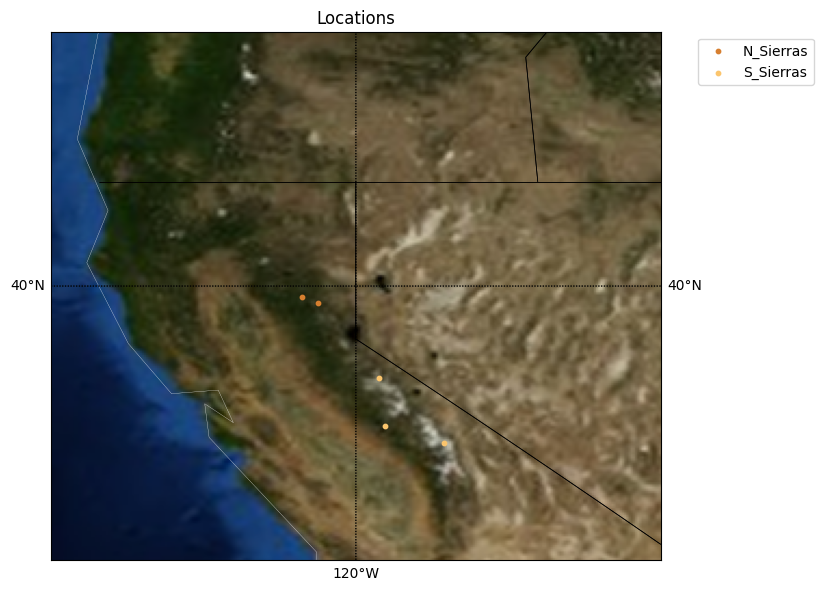

In [31]:
GeoPlot(RegionTrain)

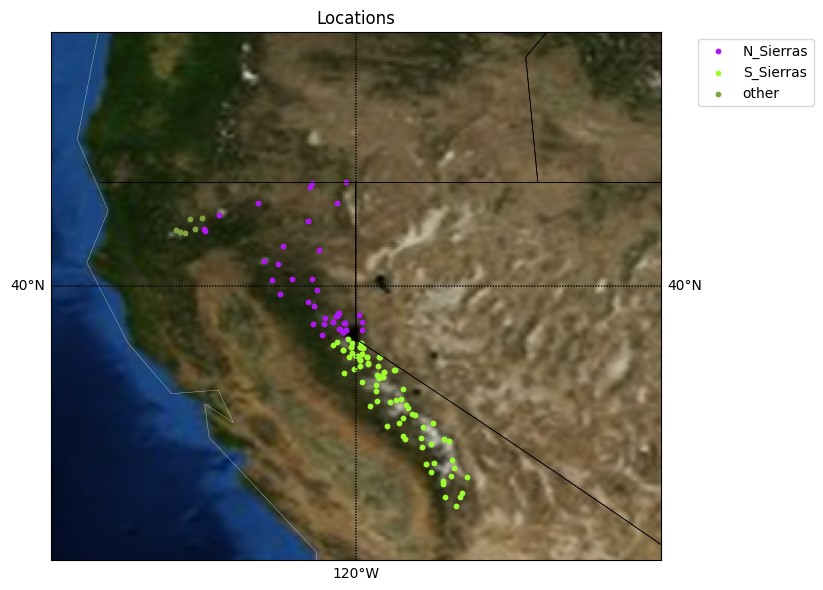

In [32]:
GeoPlot(RegionSnotel)

### Merge Geospatial data to SWE observations

In [33]:
#This function connects stationary geospatial information to observations
def Geo_to_Data(geodf, SWE, id):
    dfcols = ['Long','Lat','elevation_m','slope_deg','aspect','Date','SWE','Region']
    try:
        SWE.pop('Region')
    except:
        print(' ')
    geodf.reset_index(inplace = True)
    SWE.reset_index(inplace = True)
    datadf = SWE.merge(geodf, how='inner', on=id)
    datadf.set_index(id, inplace = True)
    datadf=datadf[dfcols]

    return datadf

#Create a temporal attribute, week_num(), that reflect the week id of the water year, beginning October 1st
def week_num(df):
        #week of water year
    weeklist = []

    for i in tqdm(range(0,len(df))):
        if df['Date'][i].month<11:
            y = df['Date'][i].year-1
        else:
            y = df['Date'][i].year
            
        WY_start = pd.to_datetime(str(y)+'-10-01')
        deltaday = df['Date'][i]-WY_start
        deltaweek = round(deltaday.days/7)
        weeklist.append(deltaweek)


    df['WYWeek'] = weeklist

In [34]:
#Merge Geospatial data to SWE observations
Snotel.set_index('station_id', inplace = True)

#Connect location geospatial attributes to observations
Training = Geo_to_Data(TrainGeo_df, TrainSWE, 'cell_id')

# get snotel station id, region, slope, and aspect to merge with obervations
GM_Snotel_train = GM_Train.copy()
#Make Date in datetime dtype
Training['Date'] = pd.to_datetime(Training['Date'])
GM_Snotel_train['Date'] = pd.to_datetime(GM_Snotel_train['Date'])

#add week number to observations
week_num(Training)

100%|██████████| 1020/1020 [00:01<00:00, 972.90it/s]


In [35]:
Training

,Long,Lat,elevation_m,slope_deg,aspect,Date,SWE,Region,WYWeek
cell_id,,,,,,,,,
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.50,3.25,263.00,2013-01-01,20.4,N_Sierras,13
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.50,3.25,263.00,2013-01-08,21.5,N_Sierras,14
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.50,3.25,263.00,2013-01-15,22.2,N_Sierras,15
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.50,3.25,263.00,2013-01-22,22.2,N_Sierras,16
018cf1a1-f945-4097-9c47-0c4690538bb5,-120.618890,39.675880,2057.50,3.25,263.00,2013-01-29,23.0,N_Sierras,17
...,...,...,...,...,...,...,...,...,...
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.552765,37.099273,3427.75,8.00,217.25,2019-02-26,17.6,S_Sierras,21
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.552765,37.099273,3427.75,8.00,217.25,2019-03-05,19.0,S_Sierras,22
2b5aab1a-08d9-4b61-8ebe-3642eda042fb,-118.552765,37.099273,3427.75,8.00,217.25,2019-03-12,22.2,S_Sierras,23


In [36]:
GM_Snotel_train

,location,elevation_m,Lat,Long,state,Date,SWE,Region
station_id,,,,,,,,
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-01,5.9,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-08,5.9,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-15,6.5,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-22,6.5,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-29,7.4,N_Sierras
...,...,...,...,...,...,...,...,...
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,2019-12-03,5.9,N_Sierras
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,2019-12-10,8.2,N_Sierras
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,2019-12-17,10.9,N_Sierras


In [38]:
#Connect observations to regional data
#subset data by each region into dictionary
RegionTrain = {name: Training.loc[Training['Region'] == name] for name in Training.Region.unique()}
RegionSnotel_Train  = {name: GM_Snotel_train.loc[GM_Snotel_train['Region'] == name] for name in GM_Snotel_train.Region.unique()}


In [39]:
RegionSnotel_Train['N_Sierras']

,location,elevation_m,Lat,Long,state,Date,SWE,Region
station_id,,,,,,,,
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-01,5.9,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-08,5.9,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-15,6.5,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-22,6.5,N_Sierras
CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,2013-01-29,7.4,N_Sierras
...,...,...,...,...,...,...,...,...
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,2019-12-03,5.9,N_Sierras
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,2019-12-10,8.2,N_Sierras
SNOTEL:848_CA_SNTL,Ward Creek #3,2055.875977,39.135448,-120.218651,California,2019-12-17,10.9,N_Sierras


### Make the Northness Feature

 <img align = 'center' src="Images/northness.JPG" alt = 'drawing' width = '300'/>

In [41]:
#This function defines northness: :  sine(Slope) * cosine(Aspect). this gives you a northness range of -1 to 1.
#Note you'll need to first convert to radians. 
#Some additional if else statements to get around sites with low obervations
def northness(df):    
    
    if len(df) == 8: #This removes single value observations, need to go over and remove these locations from training too
        #Determine northness for site
        #convert to radians
        df = pd.DataFrame(df).T
        
        df['aspect_rad'] = df['aspect']*0.0174533
        df['slope_rad'] = df['slope_deg']*0.0174533
        
        df['northness'] = -9999
        for i in range(0, len(df)):
            df['northness'].iloc[i] = math.sin(df['slope_rad'].iloc[i])*math.cos(df['aspect_rad'].iloc[i])

        #remove slope and aspects to clean df up
        df = df.drop(columns = ['aspect', 'slope_deg', 'aspect_rad', 'slope_rad', 'Region'])
        
        return df
        
    else:
         #convert to radians
        df['aspect_rad'] = df['aspect']*0.0174533
        df['slope_rad'] = df['slope_deg']*0.0174533
        
        df['northness'] = -9999
        for i in range(0, len(df)):
            df['northness'].iloc[i] = math.sin(df['slope_rad'].iloc[i])*math.cos(df['aspect_rad'].iloc[i])

        
         #remove slope and aspects to clean df up
        df = df.drop(columns = ['aspect', 'slope_deg', 'aspect_rad', 'slope_rad', 'Region'])
        
        return df

In [42]:
#make northness feature and delete regions, slope, aspect features for each training and testing cell
for i in tqdm(RegionTrain):
    RegionTrain[i] = northness(RegionTrain[i])
    
#Make dictionary in Regions dict for each region's dictionary of Snotel sites
Regions = list(RegionTrain.keys()).copy()

#Make northness for all Snotel observations
for i in tqdm(Regions):
    
    snotel = i+'_Snotel'
    RegionTrain[snotel] = {site: RegionSnotel_Train[i].loc[site] for site in RegionSnotel_Train[i].index.unique()}
    
    #get training and testing sites that are the same
    train = RegionTrain[snotel].keys()
    
    #make Northing metric
    for j in tqdm(train):
  
    #remove items we do not need
        RegionTrain[snotel][j] = RegionTrain[snotel][j].drop(columns = ['Long', 'Lat'])
    #make date index
        RegionTrain[snotel][j] = RegionTrain[snotel][j].set_index('Date')
        
    #rename columns to represent site info
        colnames = RegionTrain[snotel][j].columns
        sitecolnames = [x +'_'+ j for x in colnames]
        names = dict(zip(colnames, sitecolnames))
        RegionTrain[snotel][j] = RegionTrain[snotel][j].rename(columns = names)
    

100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


In [43]:

for i in tqdm(Regions):
    
    snotel = i+'_Snotel'
    RegionTrain[snotel] = {site: RegionSnotel_Train[i].loc[site] for site in RegionSnotel_Train[i].index.unique()}
    
    #get training and testing sites that are the same
    train = RegionTrain[snotel].keys()

    
    #get obs
    for j in tqdm(train):
   
    #remove items we do not need
        RegionTrain[snotel][j] = RegionTrain[snotel][j].drop(columns = ['Long', 'Lat', 'elevation_m', 'location', 'state' , 'Region'])
    #make date index
        RegionTrain[snotel][j] = RegionTrain[snotel][j].set_index('Date')
        
    #rename columns to represent site info
        colnames = RegionTrain[snotel][j].columns
        sitecolnames = [x +'_'+ j for x in colnames]
        names = dict(zip(colnames, sitecolnames))
        RegionTrain[snotel][j] = RegionTrain[snotel][j].rename(columns = names)
    
    #Remove unused columns
    columns = list(RegionTrain[snotel].keys()).copy()
    for col in columns:
        if len(RegionTrain[snotel][col].columns) >4:
            del RegionTrain[snotel][col]

            
#make a df for training each region, 
for R in tqdm(Regions):
    snotels = R+'_Snotel'
    RegionTrain[R] = RegionTrain[R].reset_index()
    RegionTrain[R] = RegionTrain[R].set_index('Date')
      
    for S in RegionTrain[snotels]:
        RegionTrain[R]= pd.concat([RegionTrain[R], RegionTrain[snotels][S].reindex(RegionTrain[R].index)], axis=1)
    
    RegionTrain[R] = RegionTrain[R].fillna(-9999)
    

100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


In [44]:
RegionTrain['N_Sierras'].head()

,cell_id,Long,Lat,elevation_m,SWE,WYWeek,northness,SWE_CDEC:ADM,SWE_CDEC:BKL,SWE_CDEC:BLA,...,SWE_SNOTEL:1258_CA_SNTL,SWE_SNOTEL:1277_CA_SNTL,SWE_SNOTEL:301_CA_SNTL,SWE_SNOTEL:428_CA_SNTL,SWE_SNOTEL:540_CA_SNTL,SWE_SNOTEL:541_CA_SNTL,SWE_SNOTEL:784_CA_SNTL,SWE_SNOTEL:809_CA_SNTL,SWE_SNOTEL:834_CA_SNTL,SWE_SNOTEL:848_CA_SNTL
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,018cf1a1-f945-4097-9c47-0c4690538bb5,-120.61889,39.67588,2057.5,20.4,13,-0.006909,5.9,16.56,4.92,...,-9999.0,-9999.0,5.9,18.0,5.1,33.8,31.0,6.3,10.4,14.6
2013-01-08,018cf1a1-f945-4097-9c47-0c4690538bb5,-120.61889,39.67588,2057.5,21.5,14,-0.006909,5.9,17.04,5.64,...,-9999.0,-9999.0,6.0,18.4,5.1,34.1,31.0,6.2,10.4,14.6
2013-01-15,018cf1a1-f945-4097-9c47-0c4690538bb5,-120.61889,39.67588,2057.5,22.2,15,-0.006909,6.5,18.72,7.32,...,-9999.0,-9999.0,6.6,19.3,5.3,34.5,31.9,6.8,11.0,16.8
2013-01-22,018cf1a1-f945-4097-9c47-0c4690538bb5,-120.61889,39.67588,2057.5,22.2,16,-0.006909,6.5,19.20,7.56,...,-9999.0,-9999.0,6.5,19.0,5.3,33.2,31.9,6.8,11.0,16.8
2013-01-29,018cf1a1-f945-4097-9c47-0c4690538bb5,-120.61889,39.67588,2057.5,23.0,17,-0.006909,7.4,19.08,8.28,...,-9999.0,-9999.0,7.4,19.1,5.7,34.0,32.6,6.2,11.2,17.0


### Feature Engineering: Previous Week's SNOTEL SWE

We use in-situ station SWE observations as features, using the values observed from the current (Snotel/CDEC SWE) and the previous week (Previous Snotel/CDEC SWE) as inputs.

In [48]:
def Prev_SWE_Snotel_Dict(DF, region):
    print(region)
    
    regionsnotel = region+'_Snotel'
    
    sites = DF[regionsnotel].keys()
    
    #week delta  
    weekdelta = pd.Timedelta(7, "d")
    
    for i in tqdm(sites):
        #print(i)
        prevSWE = 'Prev_SWE_' + i
        SWE = 'SWE_'+i
        
        DF[regionsnotel][i][prevSWE] = -9999.99
        
        #need to find the number of columns for ifelse
        dfcols = len(DF[regionsnotel][i].columns)
    

        #if only one observation need to fix
        if len(DF[regionsnotel][i]) == 1:
            DF[regionsnotel][i] = DF[regionsnotel][i].T

        for cell in range(1,len(DF[regionsnotel][i])):

            if DF[regionsnotel][i].index[cell] - DF[regionsnotel][i].index[cell-1] == weekdelta:     
                DF[regionsnotel][i][prevSWE][cell] = DF[regionsnotel][i][SWE][cell-1]
  

In [49]:
for i in Regions:
    Prev_SWE_Snotel_Dict(RegionTrain, i)
    

N_Sierras


100%|██████████| 44/44 [00:05<00:00,  7.94it/s]


S_Sierras


100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


In [50]:
RegionTrain['N_Sierras_Snotel']['CDEC:ADM'].head()

,SWE_CDEC:ADM,Prev_SWE_CDEC:ADM
Date,,
2013-01-01,5.9,-9999.99
2013-01-08,5.9,5.90
2013-01-15,6.5,5.90
2013-01-22,6.5,6.50
2013-01-29,7.4,6.50


### Feature Engineering: Delta SNOTEL SWE


Using the observations from the current and previous week, we calculate the difference to capture the trend, either positive or negative, in SWE dynamics (i.e, melt or accumulation) with respect to each monitoring station ( $\Delta$ SWE). 

In [51]:
def Delta_SWE_Snotel_Dict(DF, region):
    # print(region)
    
    regionsnotel = region+'_Snotel'
    
    sites = DF[regionsnotel].keys()
    
    for i in tqdm(sites):
      #  print(i)
        prevSWE = 'Prev_SWE_' + i
        SWE = 'SWE_'+i
        Delta_SWE = 'Delta_'+SWE
        
        DF[regionsnotel][i][Delta_SWE] = DF[regionsnotel][i][SWE] - DF[regionsnotel][i][prevSWE]
        DF[regionsnotel][i].loc[DF[regionsnotel][i][Delta_SWE]>150, Delta_SWE] =-9999.99
    
        

In [52]:
#Add Delta SWE feature
for i in Regions:
    Delta_SWE_Snotel_Dict(RegionTrain, i)

100%|██████████| 80/80 [00:00<00:00, 722.64it/s]


In [53]:
RegionTrain['N_Sierras_Snotel']['CDEC:ADM'].head()

,SWE_CDEC:ADM,Prev_SWE_CDEC:ADM,Delta_SWE_CDEC:ADM
Date,,,
2013-01-01,5.9,-9999.99,-9999.99
2013-01-08,5.9,5.90,0.00
2013-01-15,6.5,5.90,0.60
2013-01-22,6.5,6.50,0.00
2013-01-29,7.4,6.50,0.90


## Connect Snotel Observations to NASA ASO
Connect dataframe of NASA ASO with snotel observations

In [54]:
#make a df for training each region, 
for R in tqdm(Regions):
    snotels = R+'_Snotel'
    RegionTrain[R] = RegionTrain[R].reset_index()
    RegionTrain[R] = RegionTrain[R].set_index('Date')
    
    for S in RegionTrain[snotels]:
        RegionTrain[R]= pd.concat([RegionTrain[R], RegionTrain[snotels][S].reindex(RegionTrain[R].index)], axis=1)
    
    RegionTrain[R] = RegionTrain[R].fillna(-9999)

#Remove unnecessary features
for region in Regions:
    RegionTrain[region] = RegionTrain[region].drop( RegionTrain[region].filter(regex='elevation_m_').columns, axis=1)
    RegionTrain[region] = RegionTrain[region].drop( RegionTrain[region].filter(regex='northness_').columns, axis=1)
    RegionTrain[region] = RegionTrain[region].T.drop_duplicates().T


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


## Target Site's Previous SWE 

Because of the serial correlation of snow accumulation and melt on the current timesteps SWE prediction, the model uses the SWE estimate of the previous week as a feature (Previous SWE).
For model training and testing, the Previous SWE input is from NASA ASO datasets.

In [55]:

def Prev_SWE(df, region):    
    print(region)
    
    df = df[region].reset_index()
    df = df.set_index('cell_id')
    
    #week delta  
    weekdelta = pd.Timedelta(7, "d")

    #set up column for previous weeks SWE
    df['prev_SWE'] = -9999.99
    
    #need to find the number of columns for ifelse
    dfcols = len(df.columns)
    
    #Run through each uniqe site/cell id to calculate previous weeks SWE and add to a new dataframe
    new_df = pd.DataFrame(columns = df.columns)
    
    #find unique sites
    sites = df.index.unique()
 
    for i in tqdm(sites):
        site = df.loc[i].copy()

        #if only one observation need to fix
        if site.shape == (dfcols,):# and len(site) < 162:
            site = site.to_frame().T

        for cell in range(1,len(site)):
            if site['Date'][cell] - site['Date'][cell-1] == weekdelta:     
                site['prev_SWE'][cell] = site['SWE'][cell-1]
        dflist = [new_df, site]
        new_df = pd.concat(dflist)
    new_df = new_df.fillna(-9999)
    
    #Put Prev_SWE next to SWE to confirm operations
    prev_SWE = new_df['prev_SWE'].copy()
    del new_df['prev_SWE']
    new_df.insert(loc = 5,
          column = 'prev_SWE',
          value = prev_SWE)
    
    return new_df



In [56]:
#Run the previous SWE function and save the dataframe, you will now be ready to train the model.
training_df = {}
for region in Regions:
    training_df[region] = Prev_SWE(RegionTrain, region)

N_Sierras


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


S_Sierras


100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


In [57]:
training_df['N_Sierras'].head()

,Date,Long,Lat,elevation_m,SWE,prev_SWE,WYWeek,northness,SWE_CDEC:ADM,SWE_CDEC:BKL,...,Prev_SWE_SNOTEL:541_CA_SNTL,Delta_SWE_SNOTEL:541_CA_SNTL,Prev_SWE_SNOTEL:784_CA_SNTL,Delta_SWE_SNOTEL:784_CA_SNTL,Prev_SWE_SNOTEL:809_CA_SNTL,Delta_SWE_SNOTEL:809_CA_SNTL,Prev_SWE_SNOTEL:834_CA_SNTL,Delta_SWE_SNOTEL:834_CA_SNTL,Prev_SWE_SNOTEL:848_CA_SNTL,Delta_SWE_SNOTEL:848_CA_SNTL
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,-120.61889,39.67588,2057.5,20.4,-9999.99,13,-0.006909,5.9,16.56,...,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-08,-120.61889,39.67588,2057.5,21.5,20.40,14,-0.006909,5.9,17.04,...,33.80,0.30,31.00,0.00,6.30,-0.10,10.40,0.00,14.60,0.00
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-15,-120.61889,39.67588,2057.5,22.2,21.50,15,-0.006909,6.5,18.72,...,34.10,0.40,31.00,0.90,6.20,0.60,10.40,0.60,14.60,2.20
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-22,-120.61889,39.67588,2057.5,22.2,22.20,16,-0.006909,6.5,19.20,...,34.50,-1.30,31.90,0.00,6.80,0.00,11.00,0.00,16.80,0.00
018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-29,-120.61889,39.67588,2057.5,23.0,22.20,17,-0.006909,7.4,19.08,...,33.20,0.80,31.90,0.70,6.80,-0.60,11.00,0.20,16.80,0.20


In [167]:
training_df['S_Sierras'].head()

,Date,Long,Lat,elevation_m,SWE,prev_SWE,WYWeek,northness,SWE_CDEC:AGP,SWE_CDEC:ALP,...,Prev_SWE_SNOTEL:587_CA_SNTL,Delta_SWE_SNOTEL:587_CA_SNTL,Prev_SWE_SNOTEL:633_CA_SNTL,Delta_SWE_SNOTEL:633_CA_SNTL,Prev_SWE_SNOTEL:724_CA_SNTL,Delta_SWE_SNOTEL:724_CA_SNTL,Prev_SWE_SNOTEL:771_CA_SNTL,Delta_SWE_SNOTEL:771_CA_SNTL,Prev_SWE_SNOTEL:778_CA_SNTL,Delta_SWE_SNOTEL:778_CA_SNTL
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,-119.612777,38.279274,2861.5,37.0,-9999.99,13,-0.022456,17.52,12.75,...,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-08,-119.612777,38.279274,2861.5,37.4,37.00,14,-0.022456,17.54,13.32,...,8.80,0.60,9.40,0.50,11.40,0.20,16.10,0.40,3.40,0.30
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-15,-119.612777,38.279274,2861.5,38.6,37.40,15,-0.022456,17.85,14.26,...,9.40,0.40,9.90,0.60,11.60,0.60,16.50,0.30,3.70,0.10
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-22,-119.612777,38.279274,2861.5,38.6,38.60,16,-0.022456,17.39,14.02,...,9.80,0.00,10.50,0.00,12.20,0.00,16.80,0.00,3.80,0.00
01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-29,-119.612777,38.279274,2861.5,40.2,38.60,17,-0.022456,18.03,13.39,...,9.80,0.10,10.50,0.40,12.20,0.20,16.80,1.00,3.80,0.70


Next [Chapter](./training.ipynb)